# Eye Detection and Classification
_Ravaioli Michele - michele.ravaioli3@studio.unibo.it_

In questo progetto si propone di sviluppare un sistema basato sulla visione artificiale in grado di rilevare la posizione degli occhi all'interno di un'immagine del volto e di classificarne lo stato, distinguendo tra occhi aperti e occhi chiusi.

Questo sistema trova applicazione pratica nel settore della sicurezza stradale, dove può essere utilizzato come componente di un rilevatore di sonnolenza per i conducenti. Monitorando in tempo reale lo stato degli occhi, il sistema può contribuire a prevenire incidenti causati da affaticamento o colpi di sonno, migliorando significativamente la sicurezza durante la guida.

> Il lavoro di questo progetto si basa sul seguente paper del 2016:
> [Real-Time Eye Blink Detection using Facial Landmarks](https://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf)

## Design


In questo progetto, il problema può essere suddiviso in due fasi principali: la rilevazione degli occhi e la classificazione del loro stato. La strategia più logica consiste nell'eseguire prima la rilevazione tramite un algoritmo di detection e successivamente utilizzare il risultato per addestrare un classificatore che distingua tra occhi aperti e chiusi.

Tuttavia, come descritto nel paper [Real-Time Eye Blink Detection using Facial Landmarks](https://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf), è possibile semplificare questo processo utilizzando un detector in grado di fornire non solo la posizione degli occhi, ma anche i _landmark facciali_. In questo caso, non è necessario addestrare un ulteriore algoritmo per la classificazione: le informazioni presenti nei landmark possono essere direttamente sfruttate per distinguere tra occhi aperti e chiusi, riducendo la complessità del sistema.

Il paper evidenzia che, utilizzando i giusti landmark facciali, è possibile calcolare l'**Eye Aspect Ratio (EAR)**, una metrica che descrive geometricamente lo stato dell'occhio. L'EAR cattura informazioni relative alla forma dell'occhio, rendendolo un indicatore utile per distinguere occhi aperti e chiusi.

Dato un set di sei punti 2D intorno all'occhio, l'EAR si calcola come:

$EAR=\frac{\left \Vert p_2 - p_6 \right \| + \left \Vert p_3 - p_5 \right \|}{2\left \Vert p_1 - p_4 \right \|}$

Dove $p_1,...,p_6$ rappresentano i landmark dell'occhio, con $p_1, p_4$ che definiscono la larghezza orizzontale e $p_2, p_3, p_5, p_6$ che rappresentano le altezze verticali.

L'EAR ha due caratteristiche fondamentali:
- **Stabilità**: Rimane quasi costante quando l'occhio è aperto.
- **Variazione significativa**: Si avvicina a zero man mano che l'occhio si chiude.

Poiché gli occhi di una persona si chiudono simultaneamente, si può calcolare la media degli EAR per entrambi gli occhi per ottenere un valore più robusto.

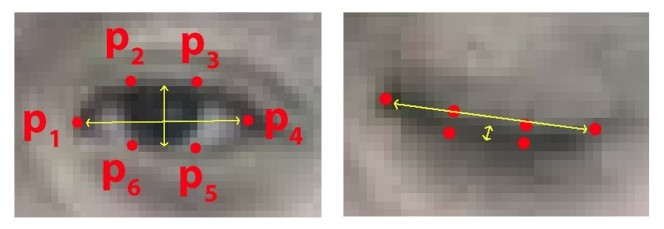

Il sistema e' quindi formato dai seguenti componenti:
- **Eye Detector**: ha i compito di rilevare i landmark degli occhi partendo da un'immagine.
- **Eye Classifier**: classifica lo stato degli occhi partendo dai landmark facciali.

## Implementazione

Per prima cosa si devono importare le librerie necessarie. Si utilizzeranno _Numpy_ e _OpenCV_ per elaborare le immagini e feature, e _DLib_ per eseguire la detection dei landmark facciali.

> NOTA: per questo progetto si e' utilizzato come detector dei landmark un modello pre-addestrato, utilizzabile tramite DLib.

In [ ]:
# get the pre-trained weights for face landmark detection
!wget -P model/ http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

# unzip
!bunzip2 model/shape_predictor_68_face_landmarks.dat.bz2

--2025-02-09 15:25:02--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-02-09 15:25:03--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘model/shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.3MB/s    in 3.5s    

2025-02-09 15:25:07 (17.3 MB/s) - ‘model/shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import dlib
from google.colab.patches import cv2_imshow

Il detector offerto da DLib e' un detector che individua 68 landmark su tutto il volto. Siccome a noi interessano solamente quelli degli occhi, occorre filtrare il risultato della detection.

In [ ]:
# these arrays contain the indeces of the keypoints we need
left_eye_points = [36, 37, 38, 39, 40, 41]
right_eye_points = [42, 43, 44, 45, 46, 47]

Implementiamo il primo componente del sistema, l'**Eye Detector**, utilizzando il modello per la detection pre-addestrato.

In [ ]:
class DetectionResult():
  """Result of the EyeDetector. Contains the landmark's coordinates of both eyes.
  """
  def __init__(self, left_eye, right_eye):
    self.left_eye = left_eye
    self.right_eye = right_eye

  def __repr__(self):
      return f'({self.left_eye}, {self.right_eye})'

class EyeDetector():
  """The detector of eye landmarks. Given a grayscale image, computes the 2D points for both eyes of all faces present.
  """
  def __init__(self):
    # face detector, necessary for landmark detection
    self.face_detector = dlib.get_frontal_face_detector()
    # 68 facial landmark detector
    self.shape_predictor = dlib.shape_predictor('model/shape_predictor_68_face_landmarks.dat')

  def detect(self, gray_img):
    """Detect the landmarks for all faces. The image must be grayscale.
    """
    # detect faces in the grayscale image
    rects = self.face_detector(gray_img, 1)

    result = []
    # loop over the face detections
    for rect in rects:
      # determine the facial landmarks for the face region
      shape = self.shape_predictor(gray_img, rect)

      # extract the left and right eye coordinates (x, y)
      left_eye = [(shape.part(p).x, shape.part(p).y) for p in left_eye_points]
      right_eye = [(shape.part(p).x, shape.part(p).y) for p in right_eye_points]

      result.append(DetectionResult(left_eye, right_eye))

    return result

Definiamo la funzione che calcola l'eye aspect ratio partendo dai sei landmark definiti sopra.

In [ ]:
def distance(pointA, pointB):
	# euclidean distance = norm2
  Ax, Ay = pointA
  Bx, By = pointB
  return np.sqrt((Bx - Ax)**2 + (By - Ay)**2)

def eye_aspect_ratio(eye):
	"""Compute the eye aspect ratio from the given set of landmarks. The input must be a list of six 2D points.
	"""
	# distances between the two sets of vertical eye landmarks
	h1 = distance(eye[1], eye[5])
	h2 = distance(eye[2], eye[4])
	# distance between the horizontal eye landmark
	w = distance(eye[0], eye[3])
	# eye aspect ratio
	ear = (h1 + h2) / (2.0 * w)
	return ear

Implementiamo il secondo componente del sistema, l'**Eye Classifier**, che utilizza le detection effettuare dal primo componente per distingure gli occhi chiusi da quelli aperti. Per distinguere le due classi utilizza l'EAR e le separa in base a un _threshold_ fissato come iperparametro.

Il classificatore assegna alle detection un _label_ che rappresenta i seguenti valori:

label | classe
------|-------
0 | occhi chiusi
1 | occhi aperti

In [ ]:
class ClassificationResult():
  """Result of the EyeClassifier. Contains the label (0=closed or 1=open) and the computed EAR.
  """
  def __init__(self, label, ear):
    self.label = label
    self.ear = ear

  def __repr__(self):
      return f'({self.label}, {self.ear})'

class EyeClassifier():
  """The eye classifier. Given a DetectionResult, classifies the eye between open and closed.
  """
  def __init__(self, threshold=0.1):
    # threshold not zero to account for errors
    self.threshold = threshold

  def predict(self, detection):
    """Classify all the eyes detected as closed (0) or open (1). input must be an array of DetectionResult.
    """
    result = []
    for d in detection:
      # compute the mean eye aspect ratio
      left_ear = eye_aspect_ratio(d.left_eye)
      right_ear = eye_aspect_ratio(d.right_eye)
      ear = (left_ear + right_ear) / 2.0
      # classify the eye
      if ear < self.threshold:
        result.append(ClassificationResult(label=0, ear=ear))
      else:
        result.append(ClassificationResult(label=1, ear=ear))
    return result

Ora possiamo combinare i due componenti in un'unica classe **Eye State Detector**, che esegue entrambe le operazioni di detection e classification.

In [ ]:
class EyeStateDetectionResult():
  """Result of the Eye State Detector. Combines detection and classification results.
  """
  def __init__(self, detection_result: DetectionResult, classification_result: ClassificationResult):
    self.label = classification_result.label
    self.ear = classification_result.ear
    self.left_eye = detection_result.left_eye
    self.right_eye = detection_result.right_eye

class EyeStateDetector():
  """Detect the eye position and whether they are closed or open.
  """
  def __init__(self, threshold=0.1):
    self.detector = EyeDetector()
    self.classifier = EyeClassifier(threshold)

  def predict(self, gray_img):
    """Detect the eyes position and state in an input image. The image must be grayscale.
    """
    # execute detection and then classification
    detection_result = self.detector.detect(gray_img)
    classification_result = self.classifier.predict(detection_result)

    return [EyeStateDetectionResult(d, c) for (d, c) in zip(detection_result, classification_result)]


## Valutazione

Per valutare le prestazioni, si e' utilizzato il dataset [Driver-Drowsiness-Dataset-D3S-](https://github.com/bindujiit/Driver-Drowsiness-Dataset-D3S-), che contiene immagini di volti con vari label tra cui `eye closed`.

> NOTA: Essendo su GoogleDrive, il dataset puo' essere utilizzato facilmente ma e' necessario che sia presente come scorciatoia all'interno del proprio drive.

In [ ]:
# mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path to dataset
dataset_path = '/content/drive/MyDrive/UNI/VisioneArtificiale/D3SSubjectData/'

# paths to open/closed eye images
eye_closed_paths = [
    'Sub1/Eyeclose/',
    'Sub2/Eyeclose/',
    'Sub3/Eyeclose/'
]
eye_open_paths = [
    'Sub1/Neutral/',
    'Sub2/Yawn/',
    'Sub3/Happy/'
]

In [ ]:
import os
from tqdm.notebook import tqdm

eye_closed_dataset = []
eye_open_dataset = []

print('Import closed eyes dataset...')
for path in eye_closed_paths:
  for img_path in tqdm(os.listdir(dataset_path + path)):
    # read image
    img = cv2.imread(dataset_path + path + img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (0,0), fx=0.4, fy=0.4)
    eye_closed_dataset.append(img)

print('Import open eyes dataset...')
for path in eye_open_paths:
  for img_path in tqdm(os.listdir(dataset_path + path)):
    # read image
    img = cv2.imread(dataset_path + path + img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (0,0), fx=0.4, fy=0.4)
    eye_open_dataset.append(img)

Import closed eyes dataset...


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

Import open eyes dataset...


  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Per valutare le prestazioni del classificatore si puo' calcolare la **confusion matrix**, dalla quale poi si possono ricavare _accuracy_, _precision_ e _recall_.

Per creare la confusion matrix si devono trovare i _true closed_, _true open_, _false closed_ e _false open_.

In [ ]:
def compute_confusion_matrix_values(threshold=0.1):
  # iterate through all images and compute Tclosed, Topen, Fclosed, Fopen
  Tclosed = 0
  Topen = 0
  Fclosed = 0
  Fopen = 0

  detector = EyeStateDetector(threshold)

  # closed eyes
  print('Closed eyes validation...')
  for img in tqdm(eye_closed_dataset):
    # detect eye state
    results = detector.predict(img)
    for result in results:
      if result.label == 0:
        Tclosed += 1 # true closed
      else:
        Fopen += 1 # false open
  # open eyes
  print("Open eyes validation...")
  for img in tqdm(eye_open_dataset):
    # detect eye state
    results = detector.predict(img)
    for result in results:
      if result.label == 1:
        Topen += 1 # true open
      else:
        Fclosed += 1 # false closed

  return (Tclosed, Fclosed, Fopen, Topen)

Per trovare il valore del threshold ideale, si esegue una _ricerca esaustiva_ su un range di possibili valori.

> Attenzione a eseguire il codice: impiega molto tempo a completarsi.

In [ ]:
%%capture
def f1_score(precision, recall):
  # compute the F1-score
  return 2 * (precision * recall) / (precision + recall + 0.001)

best_threshold = None
best_score = 0
best_confmat = None

all_thresholds = np.arange(0.025, 0.5, 0.025)
all_values = []

# find the best threshold, based on F1-score
for threshold in all_thresholds:
  Tclosed, Fclosed, Fopen, Topen = compute_confusion_matrix_values(threshold)
  precision = (Tclosed) / (Tclosed + Fclosed + 0.001)
  recall = (Tclosed) / (Tclosed + Fopen + 0.001)

  score = f1_score(precision, recall)
  all_values.append((Tclosed, Fclosed, Fopen, Topen))

  if score > best_score:
    best_score = score
    best_threshold = threshold
    best_confmat = (Tclosed, Fclosed, Fopen, Topen)

In [ ]:
print('Best threshold:', best_threshold)
print('Best F1-score:', best_score)
print("Confusion Matrix : ")
print(f"[{best_confmat[0]}] [{best_confmat[1]}]")
print(f"[{best_confmat[2]}] [{best_confmat[3]}]")

Best threshold: 0.15
Best F1-score: 0.9643155775523801
Confusion Matrix : 
[617] [44]
[1] [208]


In [ ]:
# calculate accuracy, precision, recall and f1-score for each threshold
accuracy = [((Tclosed + Topen) / (Tclosed + Fclosed + Topen + Fopen)) for Tclosed, Fclosed, Fopen, Topen in all_values]
precision = [((Tclosed) / (Tclosed + Fclosed + 0.001)) for Tclosed, Fclosed, Fopen, Topen in all_values]
recall = [((Tclosed) / (Tclosed + Fopen + 0.001)) for Tclosed, Fclosed, Fopen, Topen in all_values]
f1score = [f1_score(p, r) for p, r in zip(precision, recall)]

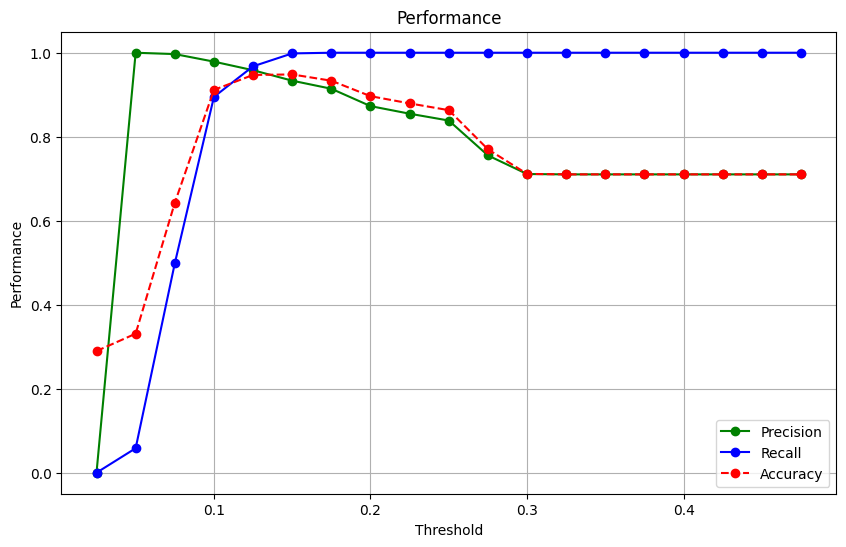

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(all_thresholds, precision, 'g', marker='o', label='Precision')
plt.plot(all_thresholds, recall, 'b', marker='o', label='Recall')
plt.plot(all_thresholds, accuracy, 'r--', marker='o', label='Accuracy')
plt.legend()
plt.title('Performance')
plt.xlabel('Threshold')
plt.ylabel('Performance')

plt.grid(True)
plt.show()

Dopo diverse iterazioni, si e' visto che il valore del threshold per la classificazione ottimale e' $threshold = 0.15$, con il quale si ottengono ottimi valori di _accuracy_, _precision_ e _recall_.

Di seguito vengono analizzate le prediction sbagliate:

In [ ]:
class BadPrediction():
  def __init__(self, img, correct_label, predicted_label, eye_positions):
    self.img = img
    self.correct_label = correct_label
    self.predicted_label = predicted_label
    self.eye_positions = eye_positions

detector = EyeStateDetector(threshold=0.15)
bad_predictions = []

print('finding bad predictions...')
# closed eyes predicted as open
for img in tqdm(eye_closed_dataset):
  results = detector.predict(img)
  for result in results:
    if result.label != 0:
      bad_predictions.append(BadPrediction(img, 0, result.label, result.left_eye + result.right_eye))

# open eyes predicted as closed
for img in tqdm(eye_open_dataset):
  results = detector.predict(img)
  for result in results:
    if result.label != 1:
      bad_predictions.append(BadPrediction(img, 1, result.label, result.left_eye + result.right_eye))

finding bad predictions...


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

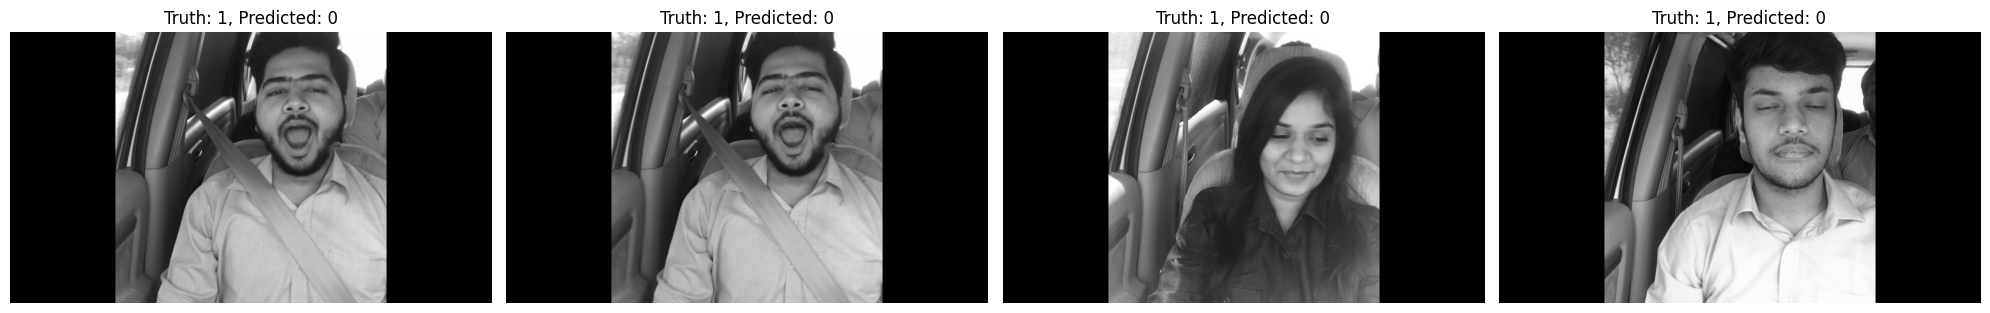

In [ ]:
# show some random wrong predictions
import random

show_bad_pred = [random.choice(bad_predictions) for i in range(4)]

_, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, pred in enumerate(show_bad_pred):
  axs[i].axis('off')
  axs[i].imshow(pred.img, cmap='gray')
  axs[i].set_title('Truth: {}, Predicted: {}'.format(pred.correct_label, pred.predicted_label))

plt.tight_layout()
plt.show()

L’analisi delle immagini ha evidenziato una criticità nel classificatore: la distinzione tra occhi aperti e chiusi risulta imprecisa nei casi di occhi socchiusi, che rappresentano una zona di ambiguità particolarmente difficile da classificare correttamente.

Un ulteriore fattore che incide sull’accuratezza è la _qualità dell’etichettatura_ del dataset, che non sempre appare affidabile.

## Conclusioni

Il sistema realizzato si dimostra altamente preciso nelle rilevazioni e particolarmente efficiente in termini di tempo di elaborazione. Durante la fase di validazione, il modello è stato in grado di processare immagini di dimensioni 770x430 con buona velocità, garantendo prestazioni in tempo reale.

Questa combinazione di accuratezza e velocità rende il modello ideale per applicazioni nei sistemi di sicurezza alla guida. Grazie alla sua capacità di elaborare immagini in modo rapido e affidabile, il sistema soddisfa le esigenze critiche di monitoraggio continuo e prevenzione di incidenti.

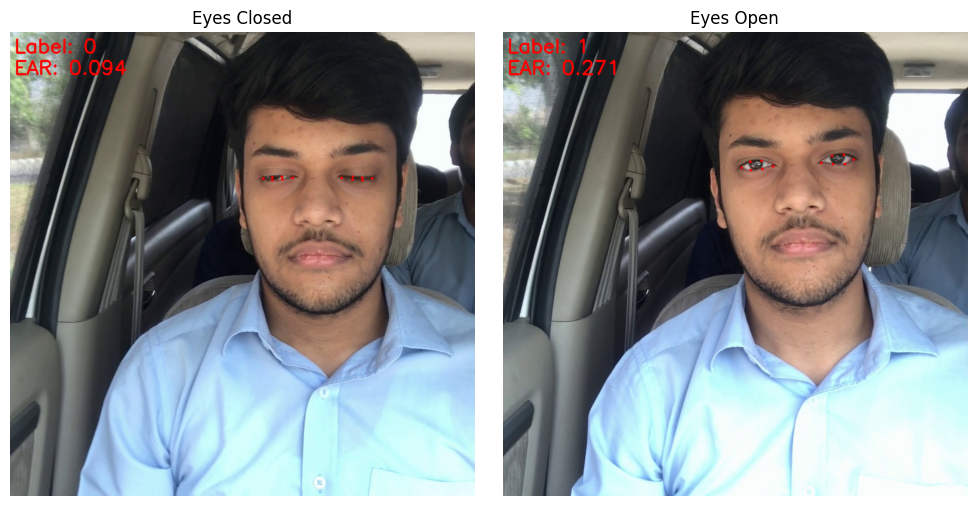

In [ ]:
# get two random images form closed and open eyes datasets and classify them
import random

margin_crop = int((1920 - 1080)/2) # used to crop the image to the center

rand_path = random.choice(os.listdir(dataset_path + eye_closed_paths[0]))
img_eye_closed = cv2.imread(dataset_path + eye_closed_paths[0] + rand_path)
img_eye_closed = img_eye_closed[:,margin_crop:-margin_crop]

rand_path = random.choice(os.listdir(dataset_path + eye_open_paths[0]))
img_eye_open = cv2.imread(dataset_path + eye_open_paths[0] + rand_path)
img_eye_open = img_eye_open[:,margin_crop:-margin_crop]

# detect eyes
detector = EyeStateDetector(0.15)

for detection in detector.predict(cv2.cvtColor(img_eye_closed, cv2.COLOR_BGR2GRAY)):
  [cv2.circle(img_eye_closed, (x, y), 3, (0, 0, 255), -1) for x,y in detection.left_eye]
  [cv2.circle(img_eye_closed, (x, y), 3, (0, 0, 255), -1) for x,y in detection.right_eye]
  cv2.putText(img_eye_closed, f"Label: {detection.label}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)
  cv2.putText(img_eye_closed, f"EAR: {round(detection.ear, 3)}", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)
for detection in detector.predict(cv2.cvtColor(img_eye_open, cv2.COLOR_BGR2GRAY)):
  [cv2.circle(img_eye_open, (x, y), 3, (0, 0, 255), -1) for x,y in detection.left_eye]
  [cv2.circle(img_eye_open, (x, y), 3, (0, 0, 255), -1) for x,y in detection.right_eye]
  cv2.putText(img_eye_open, f"Label: {detection.label}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)
  cv2.putText(img_eye_open, f"EAR: {round(detection.ear, 3)}", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)

# plot the images
plt.figure(figsize=(10, 5))

# closed eyes
plt.subplot(1, 2, 1)
plt.imshow(img_eye_closed[:,:,::-1])
plt.title("Eyes Closed")
plt.axis('off')

# open eyes
plt.subplot(1, 2, 2)
plt.imshow(img_eye_open[:,:,::-1])
plt.title("Eyes Open")
plt.axis('off')

plt.tight_layout()
plt.show()